In [118]:
from catinous.dataset import BatchDataset, ContinuousDataset
from catinous.dynamicmemory.DynamicMemoryModel import DynamicMemoryModel 
import catinous.dynamicmemory.DynamicMemoryModel as dmodel
import catinous.utils as cutils
import os
import pandas as pd
import argparse
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import catinous.evalfunctions as evalfu
import pydicom as pyd
import torch
from py_jotools import augmentation, mut

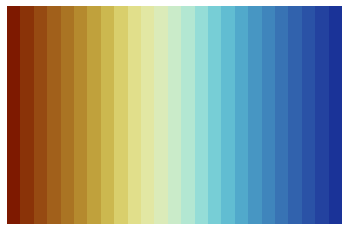

In [2]:
mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
x = np.linspace(0, 100, 25)[None, :]
plt.imshow(x, aspect='auto',cmap=colormap)
plt.axis('off')
plt.show()
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')

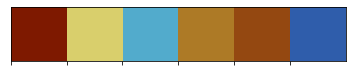

In [73]:
cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
#colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[45], cm_data[20], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())
colormap = ListedColormap([np.hstack((cm_data[0], 0)), np.hstack((cm_data[85], 1)),np.hstack((cm_data[180], 1)), np.hstack((cm_data[45], 1)), np.hstack((cm_data[20], 1)),np.hstack((cm_data[227], 1))], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm_alpha')

In [23]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplit.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': 'Siemens',
     'noncontinuous_steps': 500,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}

val_dice1_Siemens = []
val_dice2_Siemens = []
val_dice3_Siemens = []
val_dice1_GE = []
val_dice1_Philips = []
val_dice1_Canon = []

for scanner in ['Siemens', 'GE', 'Philips', 'Canon', None]:
    hparams['scanner'] = scanner
    if scanner is None:
        hparams['order'] = ['Siemens', 'GE', 'Philips', 'Canon']
    #model, logs, df_cache = catsmodel.trained_model(hparams)
    expparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    exp_name = cutils.get_expname(expparams)

    max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
    logs = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))
    
    val_dice1_Siemens.append(logs.iloc[-1].val_dice1_Siemens)
    val_dice1_GE.append(logs.iloc[-1].val_dice1_GE)
    val_dice1_Philips.append(logs.iloc[-1].val_dice1_Philips)
    val_dice1_Canon.append(logs.iloc[-1].val_dice1_Canon)

pd.DataFrame({'scanner': ['Siemens', 'GE', 'Philips', 'Canon', None], 'val_Siemens': val_dice1_Siemens, 
              'val_GE': val_dice1_GE, 'val_Philips': val_dice1_Philips, 'val_Canon': val_dice1_Canon})

,scanner,val_Siemens,val_GE,val_Philips,val_Canon
0,Siemens,0.807649,0.827656,0.843444,0.801174
1,GE,0.712092,0.826061,0.786773,0.774519
2,Philips,0.745954,0.782469,0.860170,0.828817
3,Canon,0.714380,0.752285,0.746388,0.878775
4,None,0.836838,0.848288,0.853259,0.875537


In [46]:
def res_data_for_params(hparams, seeds=None):
    df = pd.DataFrame()
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    if seeds is None:        
        exp_name = cutils.get_expname(hparams)

        max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
        df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

        df_temp = df_temp.loc[df_temp['val_dice1_Canon']==df_temp['val_dice1_Canon']]
        df_temp['idx'] = range(1,len(df_temp)+1)
        df = df.append(df_temp)
    else:
        for i, seed in enumerate(seeds):
            hparams['seed'] = seed
            hparams['run_postfix'] = i+1
            exp_name = cutils.get_expname(hparams)
            max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
            df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

            df_temp = df_temp.loc[df_temp['val_dice1_Canon']==df_temp['val_dice1_Canon']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
        df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
    else:
        print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
        df_mem = None
    
    df['val_mean_Canon'] = (df['val_dice1_Canon'] + df['val_dice2_Canon'] + df['val_dice3_Canon'])/3
    df['val_mean_GE'] = (df['val_dice1_GE'] + df['val_dice2_GE'] + df['val_dice3_GE'])/3
    df['val_mean_Siemens'] = (df['val_dice1_Siemens'] + df['val_dice2_Siemens'] + df['val_dice3_Siemens'])/3
    df['val_mean_Philips'] = (df['val_dice1_Philips'] + df['val_dice2_Philips'] + df['val_dice3_Philips'])/3

    return df, df_mem

ds = ContinuousDataset.CardiacContinuous('/project/catinous/cardiacslicessplitsingle.csv', seed=1654130)
res = ds.df.scanner == 'Siemens'
res1 = ds.df.scanner == 'GE'
res2 = ds.df.scanner == 'Philips'
res3 = ds.df.scanner == 'Canon'
res[res1] = 2
res[res2] = 3
res[res3] = 4

In [31]:

df

,created_at,epoch,train_loss,val_dice1_Canon,val_dice1_GE,val_dice1_Philips,val_dice1_Siemens,val_dice2_Canon,val_dice2_GE,val_dice2_Philips,val_dice2_Siemens,val_dice3_Canon,val_dice3_GE,val_dice3_Philips,val_dice3_Siemens,idx,val_mean_Canon,val_mean_GE,val_mean_Siemens,val_mean_Philips
0,2021-01-11 10:41:37.383322,NaN,NaN,0.823241,0.824004,0.828219,0.829606,0.664965,0.732215,0.756871,0.723660,0.622050,0.774352,0.742843,0.749166,1,0.703419,0.776857,0.767477,0.775978
1,2021-01-11 10:41:47.699709,NaN,NaN,0.819963,0.817112,0.832881,0.814098,0.663100,0.744514,0.754933,0.717598,0.615944,0.781830,0.736143,0.762967,2,0.699669,0.781152,0.764888,0.774652
2,2021-01-11 10:41:58.120596,NaN,NaN,0.815884,0.826288,0.834061,0.831348,0.655539,0.727395,0.748074,0.740688,0.624553,0.773788,0.738809,0.765870,3,0.698659,0.775824,0.779302,0.773648
3,2021-01-11 10:42:09.553293,NaN,NaN,0.819038,0.834202,0.833769,0.834558,0.664271,0.736623,0.736482,0.737270,0.630541,0.782881,0.741044,0.784216,4,0.704617,0.784568,0.785348,0.770432
5,2021-01-11 10:42:20.205168,NaN,NaN,0.808335,0.833482,0.830423,0.802783,0.678978,0.762977,0.754375,0.704584,0.602039,0.782621,0.723952,0.763173,5,0.696451,0.793027,0.756847,0.769583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2021-01-11 13:52:06.791966,NaN,NaN,0.868540,0.839096,0.864224,0.812568,0.782912,0.788476,0.801927,0.710419,0.782344,0.773909,0.766461,0.767722,22,0.811265,0.800494,0.763570,0.810871
26,2021-01-11 13:52:16.705654,NaN,NaN,0.876295,0.850827,0.859205,0.813155,0.775197,0.790493,0.784549,0.703460,0.786717,0.776570,0.762352,0.756904,23,0.812736,0.805963,0.757840,0.802035
27,2021-01-11 13:52:27.027150,NaN,NaN,0.870056,0.844052,0.855872,0.805554,0.780625,0.789719,0.779426,0.698971,0.775796,0.779391,0.741254,0.756291,24,0.808826,0.804387,0.753605,0.792184
29,2021-01-11 13:52:37.516277,NaN,NaN,0.886945,0.860884,0.858928,0.828493,0.788065,0.791657,0.778979,0.701089,0.810906,0.780875,0.757927,0.771218,25,0.828639,0.811139,0.766933,0.798611


/project/catinous/trained_cache/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_5_3e24e2e277.csv not existing


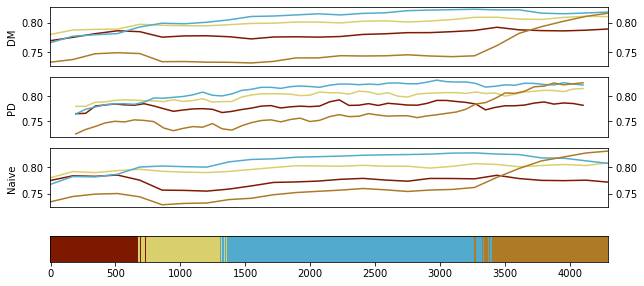

In [18]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

val_measure = 'val_mean'

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df, df_mem = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'DM')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True
        }

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True,
        'balance_memory': True,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
        }


#hparams['force_misclassified'] = True
#hparams['misclass_threshold'] = 0.80
df, df_mem = res_data_for_params(hparams, seeds=seeds)

ax = axes[1]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
#ax.set_xlim(1, 26)
ax.set_ylabel(f'PD')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt',#'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df, df_mem = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'Naive')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

/project/catinous/trained_cache/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_5_423c8dd1a7.csv not existing
/project/catinous/trained_cache/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_5_9611382680.csv not existing
/project/catinous/trained_cache/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_5_ef2d64b42f.csv not existing


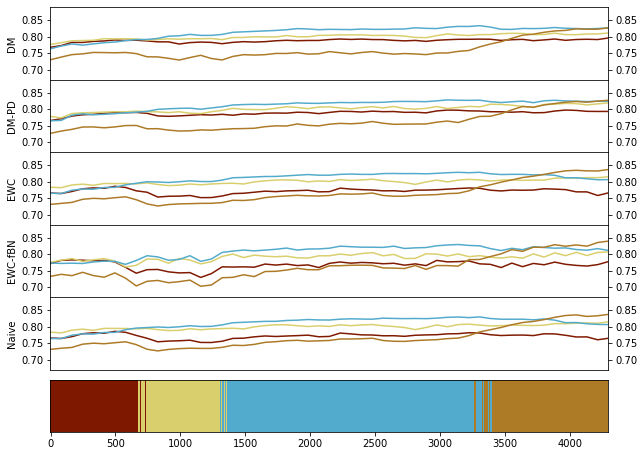

In [56]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

val_measure = 'val_mean'


hparams_set = [hparams_128_DM, hparams_128_PD, hparams_EWC_1, hparams_EWC_1_fBN, hparams_naive]


names = ['DM', 'DM-PD', 'EWC', 'EWC-fBN', 'Naive']


fig, axes = plt.subplots(len(names)+1, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.0)

for k, name in enumerate(names):
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams_set[k])
    df, df_mem = res_data_for_params(hparams, seeds=seeds)

    ax = axes[k]
    for scanner in hparams['order']:
        sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
    ax.set_ylim(0.67, 0.89)
    ax.set_yticks([0.85, 0.80, 0.75, 0.70])
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_xlim(1, 53)
    ax.set_ylabel(name)
    ax.tick_params(labelright=True, right=True)

axes[-1].imshow(np.tile(res,(400,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[-1].get_yaxis().set_visible(False)
axes[-1].get_yaxis()
plt.savefig(cutils.RESPATH + f'cardiac/cardiac_validationcurves.pdf')

In [222]:

hparams_EWC_1 = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'use_memory':False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'EWC': True,
         'EWC_lambda': 1
        }

hparams_EWC_1_fBN = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'use_memory':False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'EWC': True,
         'EWC_lambda': 1,
         'EWC_bn_off': True
        }

hparams_128_PD = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True,
        'balance_memory': True,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
        }

hparams_64_PD = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True,
        'balance_memory': True,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
        }

hparams_64_DM = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }

hparams_128_DM = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }


hparams_naive = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt',#'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

hparams_64_style = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True,
        'balance_memory': True,
         'force_misclassified': True,
          'gram_weights': [1, 1],
         'misclass_threshold': 0.8,
         'style_tile': True
        }


hparams_128_style = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True,
        'balance_memory': True,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'gram_weights': [1, 1],
         'style_tile': True
        }

seeds = [1654130, 6654961, 5819225, 1215862, 132054]

In [223]:
df_overall = pd.DataFrame()


hparams_set = [hparams_EWC_1, hparams_EWC_1_fBN, hparams_128_PD, hparams_64_PD, hparams_128_DM, hparams_64_DM, hparams_128_style, hparams_64_style, hparams_naive]


names = ['EWC_1', 'EWC_1_fBN', '128_PD', '64_PD', '128_DM', '64_DM', '128_style', '64_style', 'Naive']

for k, name in enumerate(names):
    print(name)
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams_set[k])
    df_means = pd.DataFrame()
    
    for i, seed in enumerate(seeds):
        hparams['seed'] = seed
        hparams['run_postfix'] = i+1
        if os.path.exists(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv'):
            df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
            df_temp = df.groupby(['scanner', 'shift']).mean().reset_index()
            df_temp['seed'] = seed
            df_means = df_means.append(df_temp)
        else: 
            print(name, seed, i+1, 'does not exist')

    df_res = df_means.loc[df_means['shift']=='None'].drop(columns=['seed'])

    for seed in seeds:
        df_bwt_fwt = df_means.loc[df_means.seed==seed].groupby(['scanner', 'shift']).mean().reset_index()

        order = ['Siemens', 'GE', 'Philips', 'Canon']
        bwt = {'dice_1': 0.0, 'dice_2': 0.0, 'dice_3': 0.0}
        fwt = {'dice_1': 0.0, 'dice_2': 0.0, 'dice_3': 0.0}

        for i in range(len(order)-1):
            df_scanner = df_bwt_fwt.loc[df_bwt_fwt.scanner==order[i]]
            bwt['dice_1'] += df_scanner.loc[df_scanner['shift']=='None'].dice_1.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_1.values[0]
            bwt['dice_2'] += df_scanner.loc[df_scanner['shift']=='None'].dice_2.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_2.values[0]
            bwt['dice_3'] += df_scanner.loc[df_scanner['shift']=='None'].dice_3.values[0] - df_scanner.loc[df_scanner['shift']==order[i+1]].dice_3.values[0]

        order = ['Siemens', 'GE', 'Philips', 'Canon', 'None']

        for i in range(2, len(order)):
            df_scanner = df_bwt_fwt.loc[df_bwt_fwt.scanner==order[i-1]]
            fwt['dice_1'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_1.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_1.values[0]
            fwt['dice_2'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_2.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_2.values[0]
            fwt['dice_3'] += df_scanner.loc[df_scanner['shift']==order[i]].dice_3.values[0] - df_scanner.loc[df_scanner['shift']==order[1]].dice_3.values[0]


        bwt['dice_1'] /= len(order)-1
        bwt['dice_2'] /= len(order)-1
        bwt['dice_3'] /= len(order)-1

        #bwt['mean'] = (bwt['dice_1']+bwt['dice_2']+bwt['dice_3'])/3

        fwt['dice_1'] /= len(order)-1
        fwt['dice_2'] /= len(order)-1
        fwt['dice_3'] /= len(order)-1
        df_res = df_res.append(pd.DataFrame({'scanner': ['BWT', 'FWT'], 'shift':['None', 'None'], 
                                    'dice_1':[bwt['dice_1'], fwt['dice_1']], 
                                    'dice_2':[bwt['dice_2'], fwt['dice_2']], 
                                    'dice_3':[bwt['dice_3'], fwt['dice_3']]}))


        #fwt['mean'] = (fwt['dice_1']+fwt['dice_2']+fwt['dice_3'])/3
    df_res['mean'] = df_res.mean(axis=1)
    df_res['model'] = name

    df_overall = df_overall.append(df_res)

EWC_1
EWC_1_fBN
128_PD
64_PD
128_DM
64_DM
128_style
64_style
Naive


In [6]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='mean').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']]

scanner,Siemens,GE,Philips,Canon,BWT,FWT
model,,,,,,
128_DM,0.802,0.762,0.807,0.840,-0.000,0.032
128_PD,0.799,0.763,0.809,0.844,0.003,0.031
64_DM,0.790,0.759,0.804,0.841,-0.005,0.032
64_PD,0.795,0.752,0.802,0.841,-0.006,0.031
EWC_1,0.786,0.738,0.792,0.850,-0.014,0.032
EWC_1_fBN,0.782,0.739,0.793,0.842,-0.002,0.025
Naive,0.781,0.726,0.789,0.848,-0.018,0.032


In [224]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='mean').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']]

scanner,Siemens,GE,Philips,Canon,BWT,FWT
model,,,,,,
128_DM,0.802,0.762,0.807,0.840,-0.000,0.032
128_PD,0.799,0.763,0.809,0.844,0.003,0.031
128_style,0.803,0.764,0.804,0.828,0.000,0.026
64_DM,0.790,0.759,0.804,0.841,-0.005,0.032
64_PD,0.795,0.752,0.802,0.841,-0.006,0.031
64_style,0.799,0.762,0.805,0.834,0.001,0.028
EWC_1,0.786,0.738,0.792,0.850,-0.014,0.032
EWC_1_fBN,0.782,0.739,0.793,0.842,-0.002,0.025
Naive,0.781,0.726,0.789,0.848,-0.018,0.032


In [40]:
df_overview = df_overall.groupby(['model', 'scanner']).std().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='dice_3').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']]

scanner,Siemens,GE,Philips,Canon,BWT,FWT
model,,,,,,
128_DM,0.011,0.007,0.005,0.009,0.007,0.003
128_PD,0.009,0.006,0.009,0.011,0.005,0.005
64_DM,0.010,0.007,0.007,0.008,0.004,0.006
64_PD,0.019,0.007,0.012,0.010,0.011,0.007
EWC_1,0.021,0.038,0.015,0.008,0.020,0.005
EWC_1_fBN,0.017,0.018,0.013,0.009,0.008,0.014
Naive,0.039,0.076,0.029,0.006,0.038,0.004


In [39]:
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']].to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\nscanner &  Siemens &     GE &  Philips &  Canon &    BWT &    FWT \\\\\nmodel     &          &        &          &        &        &        \\\\\n\\midrule\n128\\_DM    &    0.801 &  0.799 &    0.813 &  0.825 &  0.009 &  0.030 \\\\\n128\\_PD    &    0.796 &  0.794 &    0.814 &  0.824 &  0.009 &  0.028 \\\\\n64\\_DM     &    0.798 &  0.789 &    0.813 &  0.826 &  0.007 &  0.028 \\\\\n64\\_PD     &    0.788 &  0.781 &    0.808 &  0.823 &  0.001 &  0.028 \\\\\nEWC\\_1     &    0.763 &  0.742 &    0.796 &  0.823 & -0.020 &  0.026 \\\\\nEWC\\_1\\_fBN &    0.761 &  0.763 &    0.805 &  0.818 &  0.001 &  0.021 \\\\\nNaive     &    0.752 &  0.710 &    0.787 &  0.822 & -0.032 &  0.026 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [11]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='dice_2').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']]

scanner,Siemens,GE,Philips,Canon,BWT,FWT
model,,,,,,
128_DM,0.750,0.704,0.773,0.811,-0.008,0.044
128_PD,0.751,0.706,0.774,0.816,-0.004,0.045
64_DM,0.732,0.700,0.769,0.813,-0.015,0.047
64_PD,0.745,0.696,0.763,0.816,-0.014,0.045
EWC_1,0.743,0.693,0.751,0.825,-0.018,0.050
EWC_1_fBN,0.734,0.689,0.745,0.818,-0.011,0.046
Naive,0.741,0.692,0.753,0.824,-0.017,0.049


In [12]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='dice_3').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']]

scanner,Siemens,GE,Philips,Canon,BWT,FWT
model,,,,,,
128_DM,0.801,0.799,0.813,0.825,0.009,0.030
128_PD,0.796,0.794,0.814,0.824,0.009,0.028
64_DM,0.798,0.789,0.813,0.826,0.007,0.028
64_PD,0.788,0.781,0.808,0.823,0.001,0.028
EWC_1,0.763,0.742,0.796,0.823,-0.020,0.026
EWC_1_fBN,0.761,0.763,0.805,0.818,0.001,0.021
Naive,0.752,0.710,0.787,0.822,-0.032,0.026


In [55]:
df_overview = df_overall.groupby(['model', 'scanner']).std().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='mean').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon', 'BWT', 'FWT']]

scanner,Siemens,GE,Philips,Canon,BWT,FWT
model,,,,,,
128_DM,0.005,0.002,0.004,0.009,0.002,0.004
128_PD,0.010,0.004,0.005,0.010,0.004,0.005
64_DM,0.008,0.005,0.004,0.003,0.001,0.005
64_PD,0.009,0.004,0.006,0.004,0.006,0.006
EWC_1,0.008,0.014,0.007,0.003,0.007,0.003
EWC_1_fBN,0.002,0.007,0.007,0.006,0.004,0.007
Naive,0.013,0.026,0.011,0.003,0.012,0.002


In [56]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': None,
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}
hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
#dmodel.cached_path(hparams)

In [41]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': None,
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}
hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

df_means = pd.DataFrame()
for scanner in ['Siemens', 'GE', 'Philips', 'Canon', None]:
    hparams['scanner'] = scanner
    for i in range(5):
        hparams['run_postfix'] = i+1

        df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
        df_temp = df.groupby(['scanner']).mean().reset_index()
        if scanner is None:
            df_temp['model'] = 'Joint'
        else:
            df_temp['model'] = scanner
        df_means = df_means.append(df_temp)

df_means['mean'] = df_means.mean(axis=1)


In [15]:
df_overview = df_means.groupby(['model', 'scanner']).mean().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon']]

scanner,Canon,GE,Philips,Siemens
model,,,,
Canon,0.835,0.605,0.689,0.662
GE,0.694,0.748,0.719,0.676
Joint,0.852,0.798,0.823,0.822
Philips,0.755,0.722,0.806,0.755
Siemens,0.725,0.754,0.771,0.802


In [27]:
df_overview = df_means.groupby(['model', 'scanner']).std().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='dice_1').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon']]

scanner,Siemens,GE,Philips,Canon
model,,,,
Canon,0.025,0.041,0.024,0.007
GE,0.029,0.014,0.024,0.041
Joint,0.007,0.019,0.009,0.010
Philips,0.026,0.024,0.024,0.028
Siemens,0.015,0.026,0.025,0.010


In [43]:
df_overview = df_means.groupby(['model', 'scanner']).std().reset_index()
df_overview = df_overview.pivot(index='model', columns='scanner', values='dice_3').round(3)
df_overview[['Siemens', 'GE', 'Philips', 'Canon']]

scanner,Siemens,GE,Philips,Canon
model,,,,
Canon,0.024,0.023,0.042,0.016
GE,0.019,0.018,0.038,0.026
Joint,0.014,0.014,0.014,0.011
Philips,0.013,0.016,0.013,0.050
Siemens,0.023,0.025,0.026,0.018


## Memory evaluation

In [137]:
def get_memory_dist(hparams, seeds):
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

    df_mem_eval = pd.DataFrame()
    df_mems = []
    for k, seed in enumerate(seeds):
        hparams['seed'] = seed
        hparams['run_postfix'] = k+1
        exp_name = cutils.get_expname(hparams)
        if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
            df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
            df_mems.append(df_mem)
            df_mem_grp = df_mem.groupby('scanner').count().reset_index()
            df_mem_eval = df_mem_eval.append(df_mem_grp)
        else:
            print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
            df_mem = None
    return df_mem_eval, df_mems

In [93]:
df_mem_eval, df_mems = get_memory_dist(hparams_64_DM, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,36.6,0.0,36.6
GE,2.2,0.0,2.2
Philips,24.8,0.0,24.8
Siemens,1.0,0.0,1.0


In [94]:
df_mem_eval, df_mems = get_memory_dist(hparams_64_PD, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,36.4,36.4,36.4
GE,4.4,4.4,4.4
Philips,20.0,20.0,20.0
Siemens,3.2,3.2,3.2


In [95]:
df_mem_eval, df_mems = get_memory_dist(hparams_128_DM, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,55.8,0.0,55.8
GE,11.2,0.0,11.2
Philips,48.8,0.0,48.8
Siemens,12.2,0.0,12.2


In [96]:
df_mem_eval, df_mems = get_memory_dist(hparams_128_PD, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,58.4,58.4,58.4
GE,7.8,7.8,7.8
Philips,43.8,43.8,43.8
Siemens,18.0,18.0,18.0


In [229]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }

df_mem_eval, df_mems = get_memory_dist(hparams, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,55.8,0.0,55.8
GE,11.2,0.0,11.2
Philips,48.8,0.0,48.8
Siemens,12.2,0.0,12.2


In [153]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True,
        'balance_memory': True,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'style_tile': True
        }

df_mem_eval, df_mems = get_memory_dist(hparams, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,20.0,20.0,20.0
GE,6.0,6.0,6.0
Philips,27.2,27.2,27.2
Siemens,10.8,10.8,10.8


In [154]:
df_mems[4].groupby(['pseudo_domain', 'scanner']).count()

filepath  traincounter
pseudo_domain scanner                        
0             GE              2             2
              Philips         3             3
              Siemens         2             2
1             GE              2             2
              Philips         2             2
              Siemens         3             3
2             Canon           1             1
              Philips         4             4
              Siemens         2             2
3             GE              1             1
              Philips         3             3
              Siemens         2             2
4             Canon           3             3
              Philips         4             4
5             Canon           5             5
              Philips         2             2
6             Canon           1             1
              Philips         6             6
7             Canon           5             5
              Philips         3             3
8             Canon           8             8

In [146]:
df_mem_eval, df_mems = get_memory_dist(hparams_64_PD, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,36.4,36.4,36.4
GE,4.4,4.4,4.4
Philips,20.0,20.0,20.0
Siemens,3.2,3.2,3.2


In [37]:
df_mems[0].groupby(['pseudo_domain', 'scanner']).count()

filepath  traincounter
pseudo_domain scanner                        
0             Canon           6             6
              GE              1             1
              Philips         6             6
              Siemens         8             8
1             Canon          18            18
              GE              2             2
              Philips        14            14
2             Canon           7             7
              Philips         2             2

In [36]:
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
Canon,36.4,36.4,36.4
GE,4.4,4.4,4.4
Philips,20.0,20.0,20.0
Siemens,3.2,3.2,3.2


In [87]:
df_mems[2].groupby(['pseudo_domain', 'scanner']).count()

filepath  traincounter
pseudo_domain scanner                        
0             Canon          13            13
              GE              6             6
              Philips         3             3
1             Canon          18            18
              GE              3             3
              Philips        10            10
              Siemens         1             1
2             Canon           9             9
              Philips         1             1

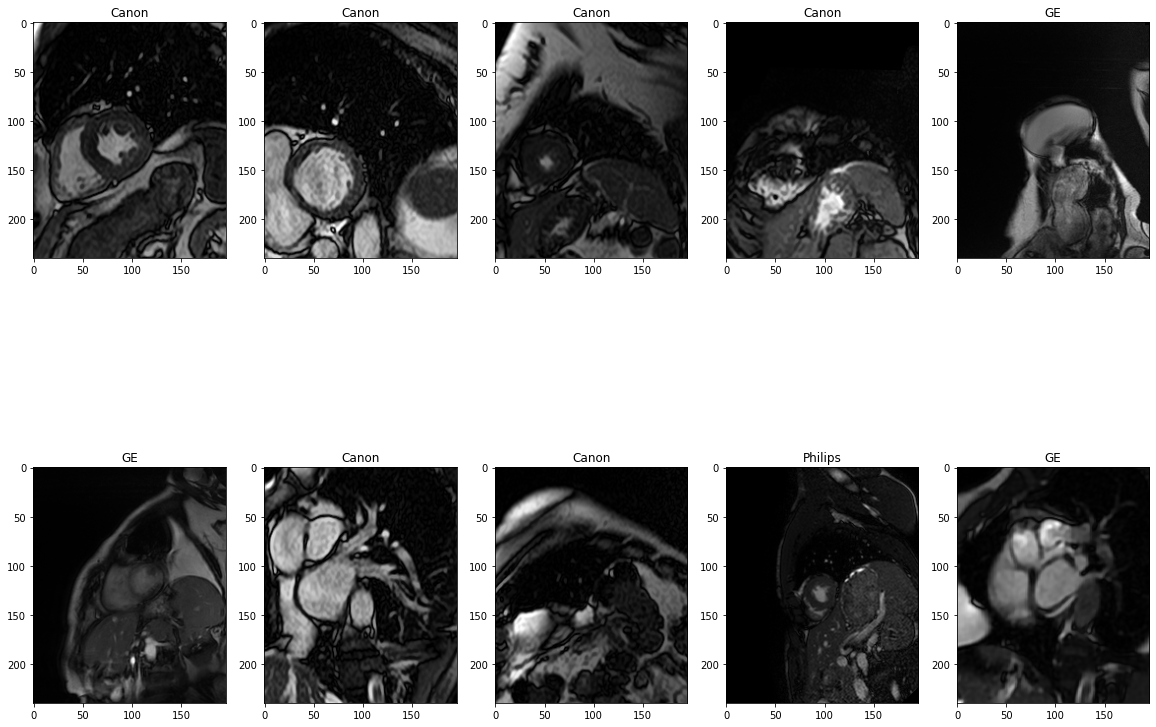

In [88]:
df_temp = df_mems[2]
df_temp = df_temp.loc[df_temp.pseudo_domain==0]

pd_sample  = df_temp.sample(10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(20, 15))

for i in range(10):
    sl = np.load(pd_sample.iloc[i].filepath)
    axes[int(i/5)][i%5].imshow(sl)
    axes[int(i/5)][i%5].set_title(pd_sample.iloc[i].scanner)

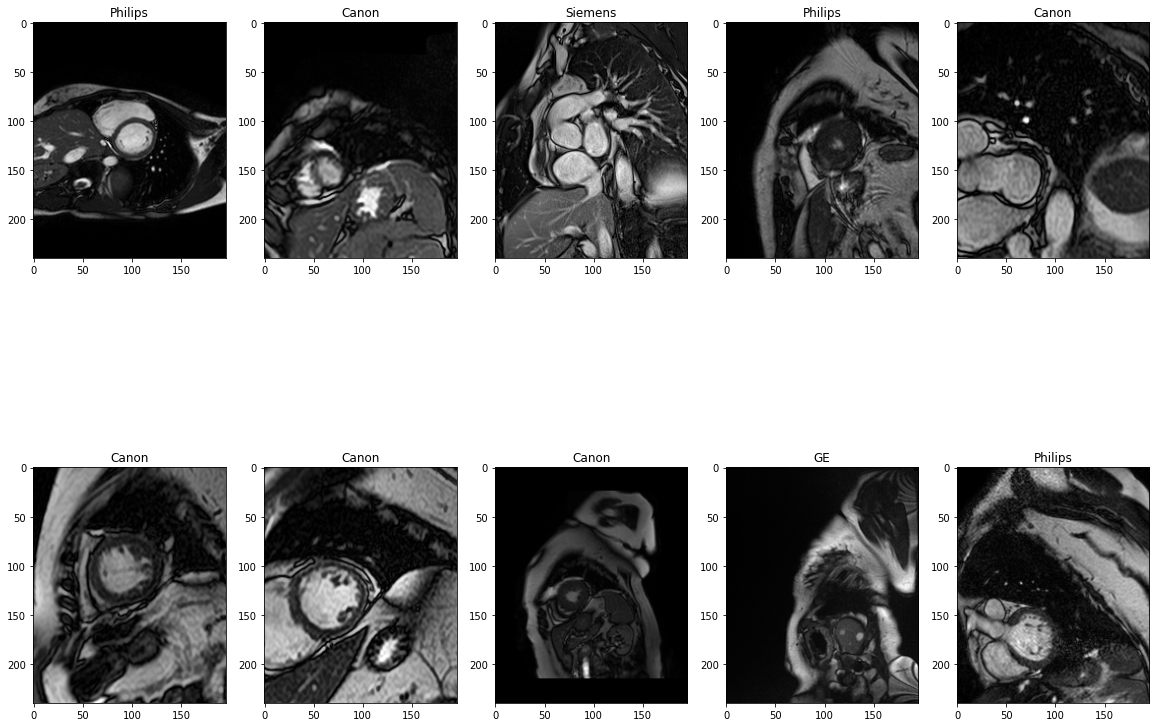

In [89]:
df_temp = df_mems[2]
df_temp = df_temp.loc[df_temp.pseudo_domain==1]

pd_sample  = df_temp.sample(10)

fig, axes = plt.subplots(2, 5, figsize=(20, 15))

for i in range(10):
    sl = np.load(pd_sample.iloc[i].filepath)
    axes[int(i/5)][i%5].imshow(sl)
    axes[int(i/5)][i%5].set_title(pd_sample.iloc[i].scanner)

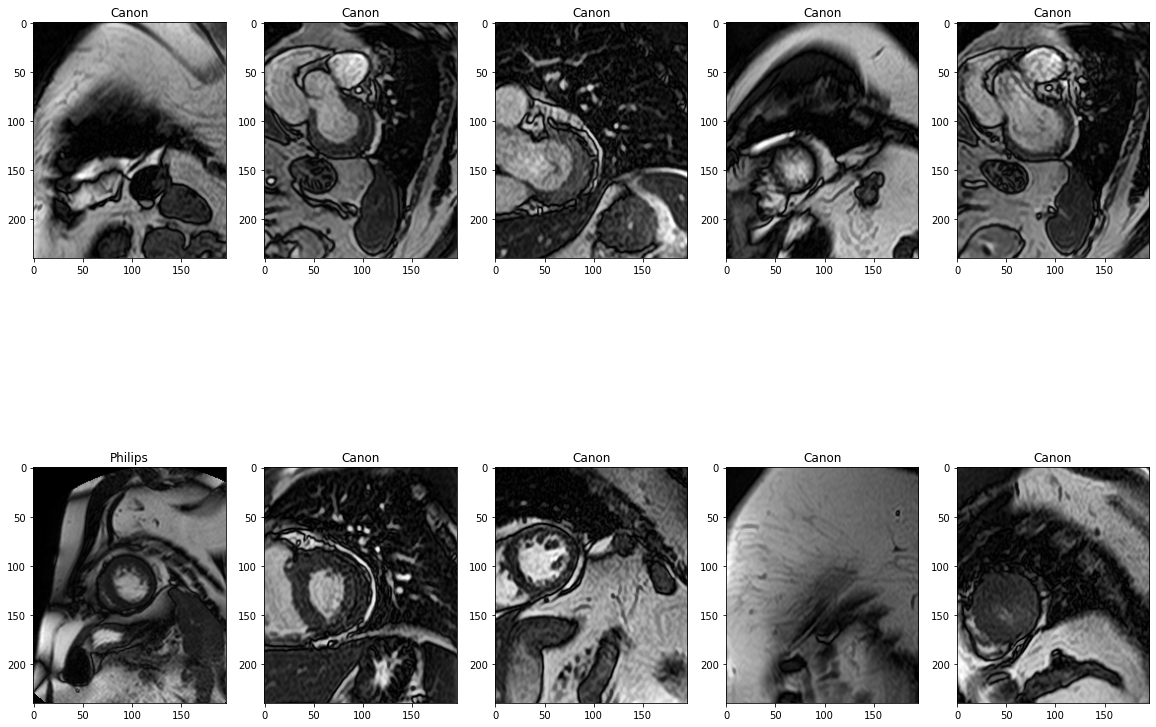

In [91]:
df_temp = df_mems[2]
df_temp = df_temp.loc[df_temp.pseudo_domain==2]

pd_sample  = df_temp.sample(min(10, len(df_temp)))

fig, axes = plt.subplots(2, 5, figsize=(20, 15))

for i in range(len(pd_sample)):
    sl = np.load(pd_sample.iloc[i].filepath)
    axes[int(i/5)][i%5].imshow(sl)
    axes[int(i/5)][i%5].set_title(pd_sample.iloc[i].scanner)

In [92]:
pd.read_csv('/project/catinous/cardiacslicessplitsingle.csv')

,scanner,filepath,t,slice,split,slicepath
0,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,0,base,/project/catinous/cardiac_data/singleSlices/D4...
1,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,1,base,/project/catinous/cardiac_data/singleSlices/D4...
2,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,2,base,/project/catinous/cardiac_data/singleSlices/D4...
3,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,3,base,/project/catinous/cardiac_data/singleSlices/D4...
4,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,4,base,/project/catinous/cardiac_data/singleSlices/D4...
...,...,...,...,...,...,...
7315,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,9,test,/project/catinous/cardiac_data/singleSlices/N7...
7316,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,10,test,/project/catinous/cardiac_data/singleSlices/N7...
7317,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,11,test,/project/catinous/cardiac_data/singleSlices/N7...
7318,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,12,test,/project/catinous/cardiac_data/singleSlices/N7...


In [15]:
device = torch.device('cuda')

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 8,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }

model, _, _, _ = dmodel.trained_model(hparams, training=False)
model.eval()
model.to(device)
print('.')

expname cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_74d6ae211e
Read: /project/catinous/trained_models/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_74d6ae211e.pt
.


In [16]:
ds = BatchDataset.CardiacBatch('/project/catinous/cardiacslicessplitsingle.csv', split='test', iterations=None, res=None)

init cardiac batch with datasetfile /project/catinous/cardiacslicessplitsingle.csv


In [191]:
min_dice = {'Siemens': 1, 'GE': 1, 'Philips': 1, 'Canon': 1}
min_idx = {'Siemens': -1, 'GE': -1, 'Philips': -1, 'Canon': -1}
max_dice = {'Siemens': 0, 'GE': 0, 'Philips': 0, 'Canon': 0}
max_idx = {'Siemens': -1, 'GE': -1, 'Philips': -1, 'Canon': -1}

for idx in range(len(ds)):
    img = ds[idx][0][None, :, :, :].to(device)
    out = model(img)
    out_mask = out['out'].cpu().detach()
    out_mask = torch.argmax(out_mask, dim=1).numpy()

    curr_dice = mut.dice(ds[idx][1], out_mask[0], classi=1)
    if curr_dice!=0 and curr_dice!=1 and curr_dice<min_dice[ds[idx][2]]:
        min_dice[ds[idx][2]] = curr_dice
        min_idx[ds[idx][2]] = idx
    
    if curr_dice!=0 and curr_dice!=1 and curr_dice>max_dice[ds[idx][2]]:
        max_dice[ds[idx][2]] = curr_dice
        max_idx[ds[idx][2]] = idx

In [200]:
print(mut.dice(ds[idx][1], out_mask[0], classi=1))
print(mut.dice(ds[idx][1], out_mask[0], classi=2))
print(mut.dice(ds[idx][1], out_mask[0], classi=3))

Siemens
GE
Philips
Canon


expname cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_1_264095f6f9
Read: /project/catinous/trained_models/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_1_264095f6f9.pt
101 0.9638370765131329
12 0.4574468085106383
639 0.983623657035569
445 0.14736842105263157
303 0.9665203073545554
284 0.11914893617021277
746 0.9854201112280174
837 0.34391723153763826
init cardiac batch with datasetfile /project/catinous/cardiacslicessplitsingle.csv
expname cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_1_a1ed3aefa3
Read: /project/catinous/trained_models/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_nomem_tf08_1_a1ed3aefa3.pt
101 0.9622857142857143
12 0.5728155339805825
639 0.9837849147400356
445 0.17307692307692307
303 0.9674418604651163
284 0.11914893617021277
746 0.9852409638554217
837 0.5695364238410596
expname cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_74d6ae211e
Read: /project/catinous/trained_models/cardiac_cont

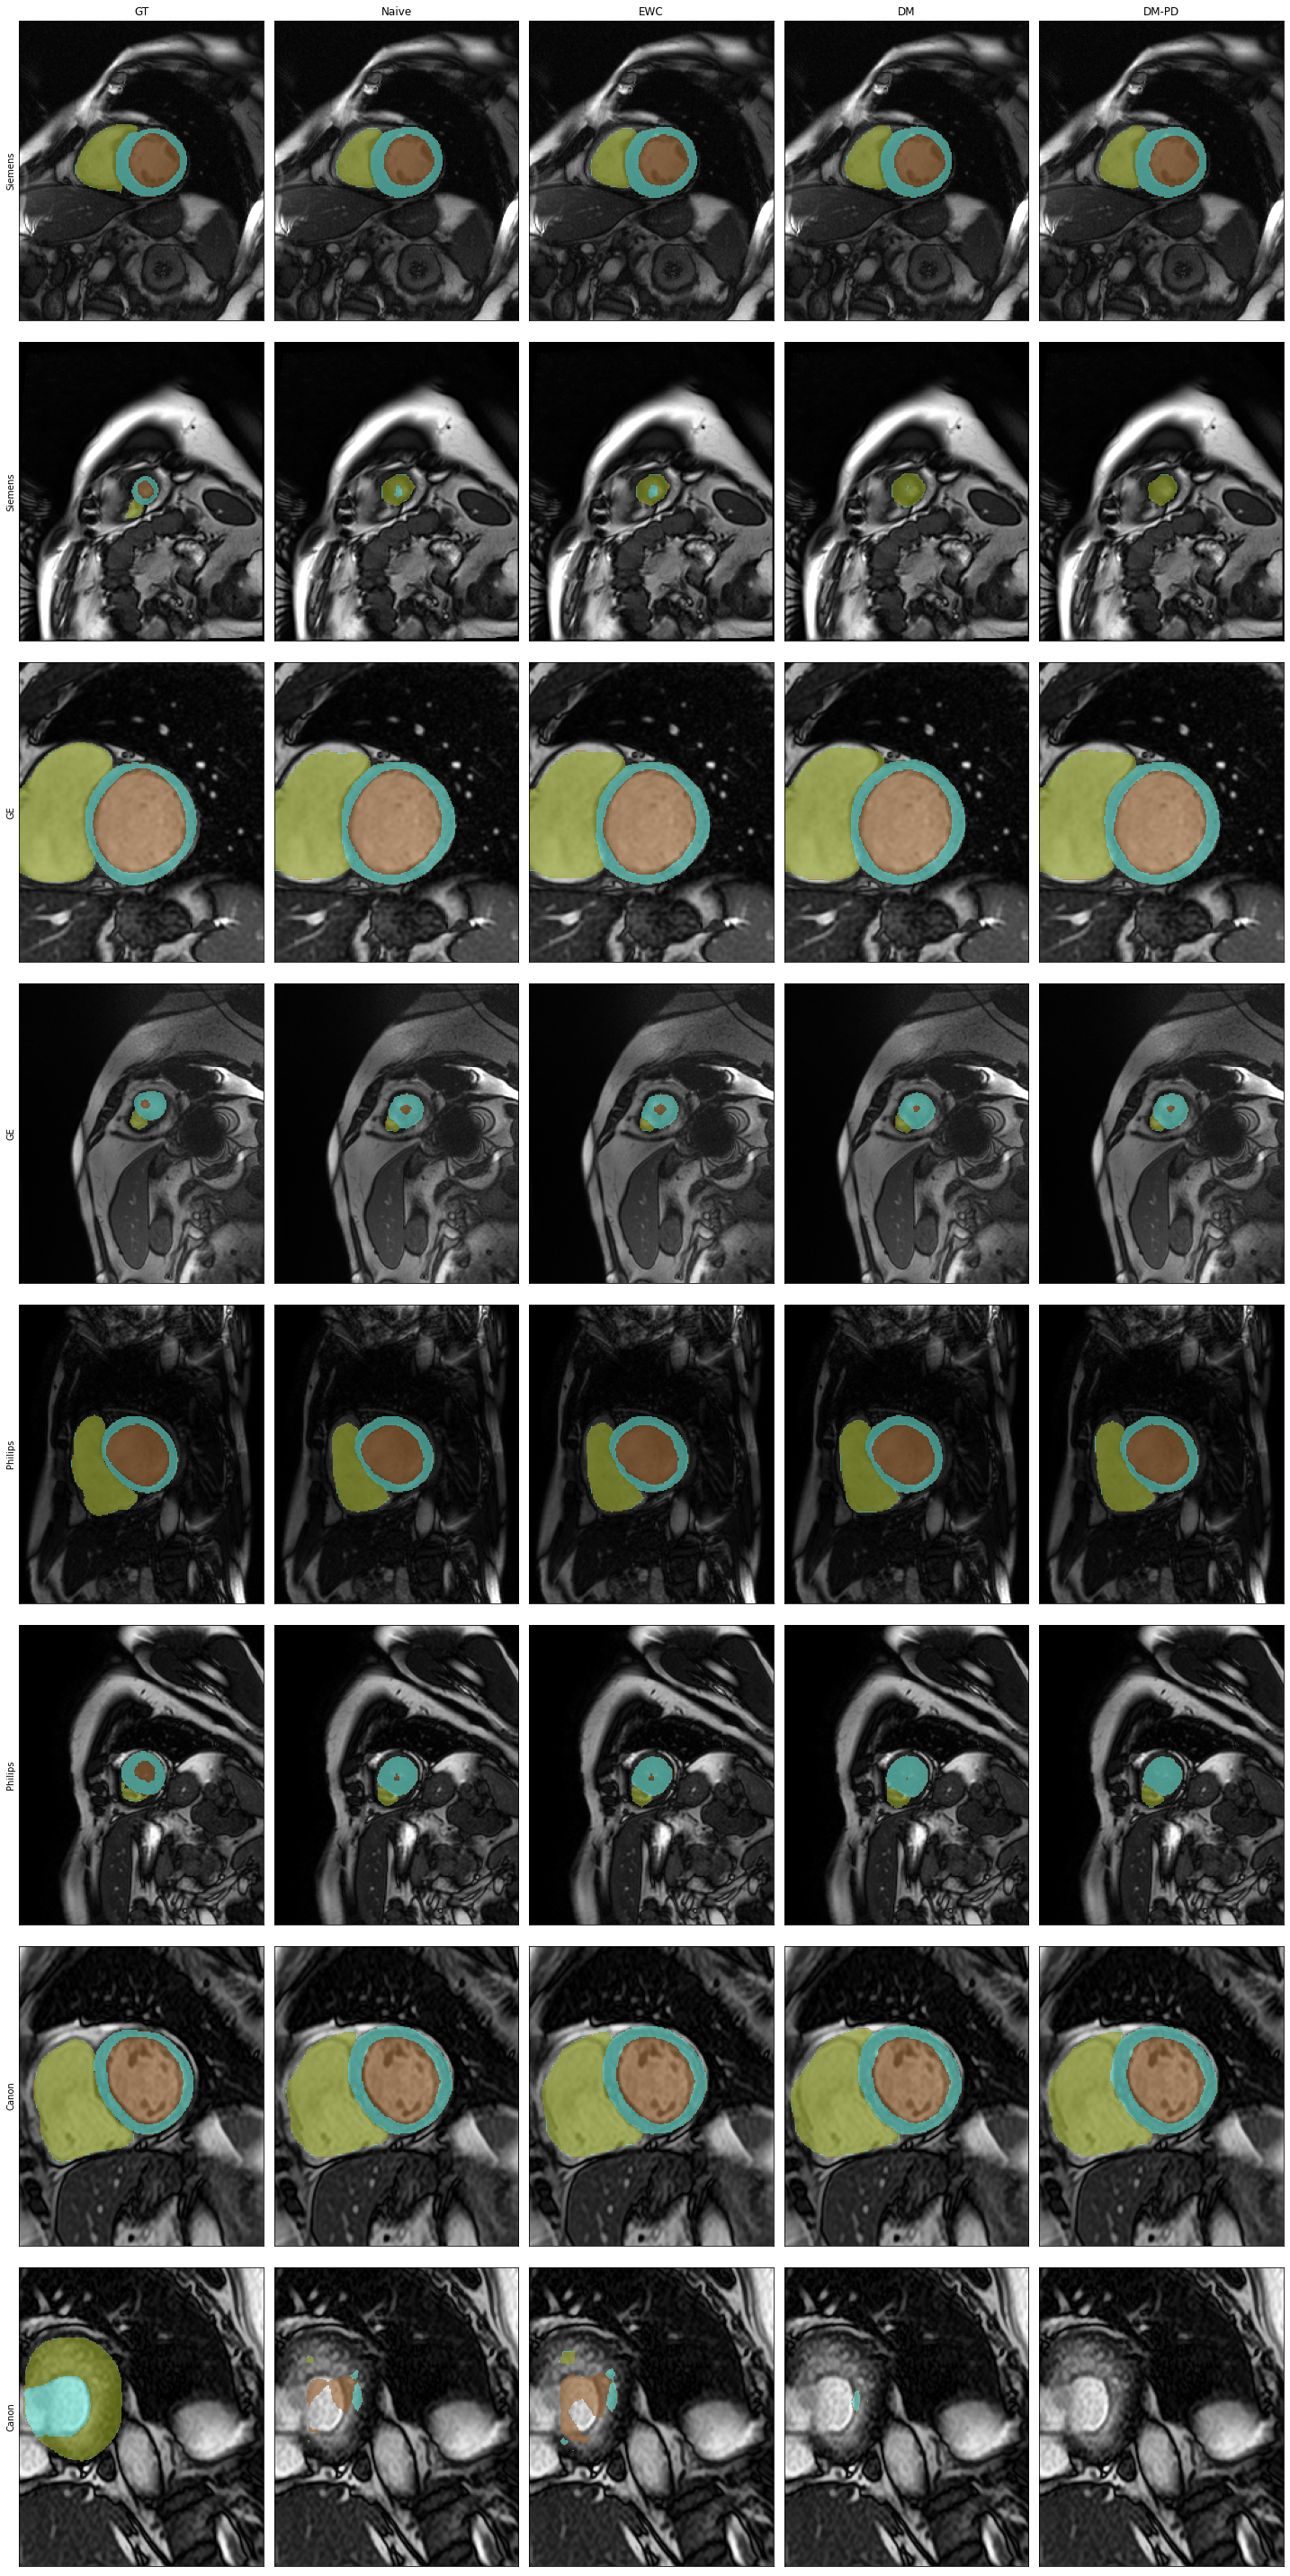

In [225]:
hparams_set = [hparams_naive, hparams_EWC_1, hparams_128_DM, hparams_128_PD]


fig, ax = plt.subplots(len(min_idx)*2, len(hparams_set)+1, figsize=(20, 40))
plt.subplots_adjust(hspace=0.1, wspace=0.1)

ax[0][0].set_title('GT')
ax[0][1].set_title('Naive')
ax[0][2].set_title('EWC')
ax[0][3].set_title('DM')
ax[0][4].set_title('DM-PD')

for i, k in enumerate(min_idx):
    idx = max_idx[k]
    img = ds[idx][0][None, :, :, :]

    ax[2*i][0].imshow(img[0][0], vmax=0.5)
    ax[2*i][0].imshow(ds[idx][1], cmap='scientific_cm_alpha', alpha=0.6)
    ax[2*i][0].get_xaxis().set_visible(False)
    #ax[2*i][0].get_yaxis().set_visible(False)
    ax[2*i][0].set_ylabel(ds[idx][2])
    ax[2*i][0].set_yticks([])


    idx = min_idx[k]
    img = ds[idx][0][None, :, :, :]

    ax[(2*i)+1][0].imshow(img[0][0], vmax=0.5)
    ax[(2*i)+1][0].imshow(ds[idx][1], cmap='scientific_cm_alpha', alpha=0.6)
    ax[(2*i)+1][0].get_xaxis().set_visible(False)
    #ax[(2*i)+1][0].get_yaxis().set_visible(False)
    ax[(2*i)+1][0].set_ylabel(ds[idx][2])
    ax[(2*i)+1][0].set_yticks([])


for j, hparams_curr in enumerate(hparams_set):
    curr_model, _, _, _ = dmodel.trained_model(hparams_curr, training=False)
    curr_model.eval()
    curr_model.to(device)
    
    for i, k in enumerate(min_idx):

        idx = max_idx[k]
        img = ds[idx][0][None, :, :, :].to(device)
        out = curr_model(img)
        out_mask = out['out'].cpu().detach()
        out_mask = torch.argmax(out_mask, dim=1).numpy()

        ax[2*i][j+1].imshow(img.cpu().detach()[0][0], vmax=0.5)
        ax[2*i][j+1].imshow(out_mask[0], alpha=0.6, cmap='scientific_cm_alpha')
        ax[2*i][j+1].get_xaxis().set_visible(False)
        ax[2*i][j+1].get_yaxis().set_visible(False)
        print(idx, mut.dice(ds[idx][1], out_mask[0], classi=1))

        idx = min_idx[k]
        img = ds[idx][0][None, :, :, :].to(device)
        out = curr_model(img)
        out_mask = out['out'].cpu().detach()
        out_mask = torch.argmax(out_mask, dim=1).numpy()

        ax[(2*i)+1][j+1].imshow(img.cpu().detach()[0][0], vmax=0.5)
        ax[(2*i)+1][j+1].imshow(out_mask[0], alpha=0.6, cmap='scientific_cm_alpha')
        ax[(2*i)+1][j+1].get_xaxis().set_visible(False)
        ax[(2*i)+1][j+1].get_yaxis().set_visible(False)
        
        print(idx, mut.dice(ds[idx][1], out_mask[0], classi=1))

plt.tight_layout()
plt.savefig(cutils.RESPATH+'/cardiac/segmentation_samples.pdf')

0.06802721088435375
0.6038216560509554
0.0


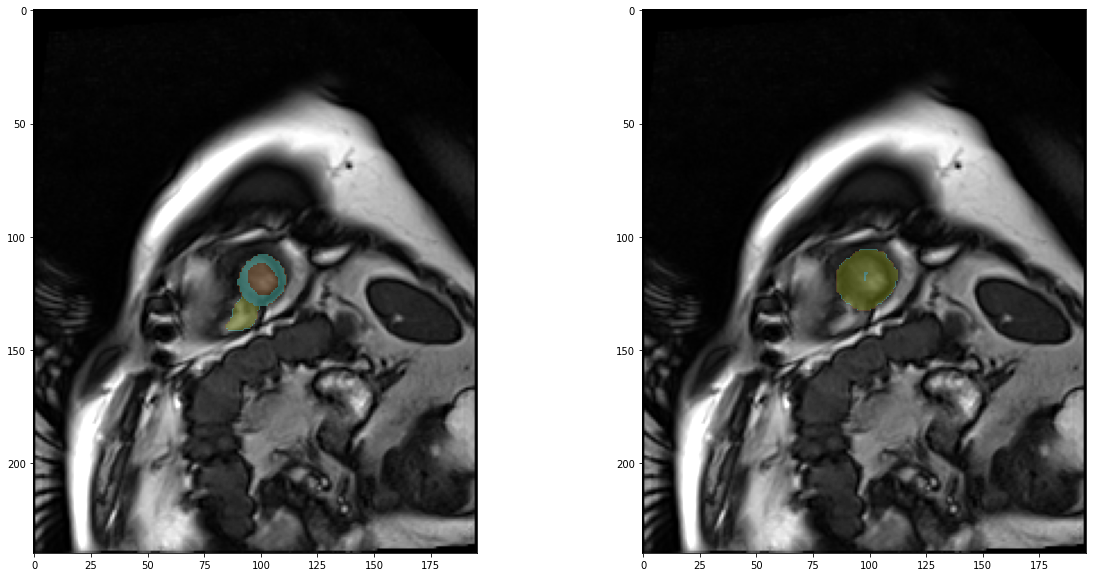

In [199]:
idx = 12

fig, ax = plt.subplots(1,2, figsize=(20, 10))


img = ds[idx][0][None, :, :, :].to(device)
out = model(img)
out_mask = out['out'].cpu().detach()
out_mask = torch.argmax(out_mask, dim=1).numpy()

ax[0].imshow(img.cpu().detach()[0][0], vmax=0.5)
ax[0].imshow(ds[idx][1], cmap='scientific_cm_alpha', alpha=0.4)

ax[1].imshow(img.cpu().detach()[0][0], vmax=0.5)
ax[1].imshow(out_mask[0], alpha=0.4, cmap='scientific_cm_alpha')

print(mut.dice(ds[idx][1], out_mask[0], classi=1))
print(mut.dice(ds[idx][1], out_mask[0], classi=2))
print(mut.dice(ds[idx][1], out_mask[0], classi=3))

In [128]:
len(ds)

942

In [192]:
print(max_idx, max_dice, min_idx, min_dice)

{'Siemens': 101, 'GE': 639, 'Philips': 303, 'Canon': 746} {'Siemens': 0.9757575757575757, 'GE': 0.9806007509386734, 'Philips': 0.9787001638448936, 'Canon': 0.9786715417428398} {'Siemens': 12, 'GE': 445, 'Philips': 284, 'Canon': 837} {'Siemens': 0.06802721088435375, 'GE': 0.06060606060606061, 'Philips': 0.0273972602739726, 'Canon': 0.03800904977375565}


In [190]:
ds[idx][2]

'Philips'

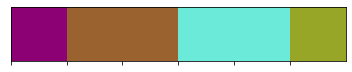

In [185]:
mapname = 'hawaii'
cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")

colormap = ListedColormap([np.hstack((cm_data[0], 0)), np.hstack((cm_data[85], 1)), np.hstack((cm_data[227], 1)), np.hstack((cm_data[140], 1))], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm_alpha')
sns.palplot(sns.color_palette('scientific_cm_alpha'))

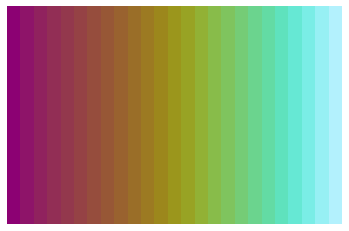

In [166]:
mapname = 'hawaii'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
x = np.linspace(0, 100, 25)[None, :]
plt.imshow(x, aspect='auto',cmap=colormap)
plt.axis('off')
plt.show()
#matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
#sns.set_palette('scientific_cm')